# Library

In [1]:
# Installation
%pip install --quiet mesa

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import math
import random

# Class Definition

## Agent

In [3]:
class ChartistAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned, chartist_day_reference):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value = self.fiat + (self.bitcoin * self.model.price)
        self.is_close = True
        self.n = chartist_day_reference
        
        # Default Rule : EMA for both opening and closing
        self.is_open_sma_high = False
        self.is_close_sma_high = False
        
        if (np.random.uniform() <= 0.25):
            # Rule : SMA for both opening and closing             
            self.is_open_sma_high = True
            self.is_close_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.5):
            # Rule : SMA for opening and EMA for closing
            self.is_open_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.75):
            # Rule : EMA for opening and SMA for closing
            self.is_close_sma_high = True
    
    def step(self):
        if self.is_close:
            # Potential Buy
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()
            
            # Count Probability to Buy Based on Rule
            probability_to_buy = 0
            if self.model.price < sma_value:
                probability_to_buy += (0.8 if self.is_open_sma_high else 0.2)
            
            if self.model.price > ema_value:
                probability_to_buy += (0.8 if not self.is_open_sma_high else 0.2)
            
            # Actual Buy
            if (np.random.uniform() <= probability_to_buy):
                self.is_close = False
                
                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained
                self.model.number_of_open_position += 1
    
        else:
            # Potential Sell
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()

            # Count Probability to Sell Based on Rule
            probability_to_sell = 0
            if self.model.price > sma_value:
                probability_to_sell += (0.8 if self.is_close_sma_high else 0.2)
            
            if self.model.price < ema_value:
                probability_to_sell += (0.8 if not self.is_close_sma_high else 0.2)
            
            # Actual Sell
            if (np.random.uniform() <= probability_to_sell):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += bitcoin_released
                self.model.number_of_open_position -= 1
        
        self.total_value = self.fiat + (self.bitcoin * self.model.price)
                    
    # Agent Helper Function
    # SMA Rule
    def calculate_sma_n_days(self):
        start_index = max(0, len(self.model.price_history) - self.n)
        window = self.model.price_history[start_index:len(self.model.price_history)]

        return sum(window) / len(window)

    # EMA Rule
    def calculate_ema_n_days(self):
        smooth_factor = 2 / (self.n + 1)
        ema = [self.model.price_history[0]]

        for i in range(1, len(self.model.price_history)):
            value = smooth_factor * self.model.price_history[i] + (1 - smooth_factor) * ema[i-1]
            ema.append(value)

        return ema[len(ema)-1]

In [4]:
class RandomAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value = self.fiat + (self.bitcoin * self.model.price)
        self.is_close = True
    
    def step(self):
        if self.is_close:
            # Actual Buy
            if (random.choice([True, False])):
                self.is_close = False

                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained
                self.model.number_of_open_position += 1
    
        else:
            # Actual Sell
            if (random.choice([True, False])):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += bitcoin_released
                self.model.number_of_open_position -= 1

        self.total_value = self.fiat + (self.bitcoin * self.model.price)

In [5]:
import random

class BitcoinMarketModel(mesa.Model):
    def __init__(self, price_start, number_of_agents, total_fiat, total_bitcoin, chartist_ratio, chartist_day_reference):
        self.schedule = mesa.time.RandomActivation(self)
        
        self.price = price_start
        self.price_history = [price_start]
        self.number_of_agents = number_of_agents
        
        self.total_fiat = total_fiat
        self.total_bitcoin = total_bitcoin
        self.supply = 0
        self.demand = 0
        
        self.number_of_open_position = 0

        # For Intermediary Process
        self.steps = 0
        self.agents = []
        
        self.chartist_ratio = chartist_ratio
        self.initial_fiat_owned = self.total_fiat / self.number_of_agents
        self.chartist_day_reference = chartist_day_reference
        
        # For Batch Run         
        self.running = True

        for i in range(self.number_of_agents):
            fiat_owned = self.initial_fiat_owned
            bitcoin_owned = 0
            
            if (np.random.uniform() <= self.chartist_ratio):
                a = ChartistAgent(str(f"chartist-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned, 
                              chartist_day_reference)

                self.schedule.add(a)
                self.agents.append(a)
            else:
                a = RandomAgent(str(f"random-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned)

                self.schedule.add(a)
                self.agents.append(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"Price": "price", 
                             "Number_of_agents": "number_of_agents", 
                             "Number_of_open_position": "number_of_open_position"}, 
            agent_reporters={"Fiat": "fiat", 
                             "Bitcoin": "bitcoin", 
                             "TV": "total_value", 
                             "OpenSMA": "is_open_sma_high", 
                             "CloseSMA": "is_close_sma_high"}
        )
    
    def step(self):
        # Before Stepping
        self.price += self.calculate_today_price_change()
        self.supply = 0
        self.demand = 0
        
        self.datacollector.collect(self)
        
        # Stepping
        self.schedule.step()
        self.steps += 1
        
        # After Stepping
        self.price_history.append(self.price)
        
        # Monthly Adjustment
        if (self.steps % 30 == 0):
            # Add New Agents
            old_number_of_agents = self.number_of_agents
            self.number_of_agents += math.floor(0.6 * self.number_of_agents / 12)
            
            for i in range(self.number_of_agents - old_number_of_agents):
                fiat_owned = self.initial_fiat_owned
                bitcoin_owned = 0
                chartist_day_reference = self.chartist_day_reference

                if (np.random.uniform() <= self.chartist_ratio):
                    a = ChartistAgent(str(f"add-chartist-@{self.steps}-{i}"), 
                                  self, 
                                  fiat_owned,
                                  bitcoin_owned, 
                                  chartist_day_reference)

                    self.schedule.add(a)
                    self.agents.append(a)
                else:
                    a = RandomAgent(str(f"add-random-@{self.steps}-{i}"), 
                                  self, 
                                  fiat_owned,
                                  bitcoin_owned)

                    self.schedule.add(a)
                    self.agents.append(a)
                    
            # Add New Bitcoins to Traders
            valuable_agents = []
            total_bitcoin_in_agents = 0
            for i in range(len(self.agents)):
                agent = self.agents[i]
                
                if (agent.bitcoin != 0):
                    valuable_agents.append(agent)
                    total_bitcoin_in_agents += agent.bitcoin
            
            total_new_bitcoin = round(0.076 * self.total_bitcoin, 4)
            self.total_bitcoin += total_new_bitcoin
            
            for i in range(len(valuable_agents)):
                agent = valuable_agents[i]
                
                ratio = agent.bitcoin / total_bitcoin_in_agents
                
                agent.bitcoin += round(ratio * total_new_bitcoin, 4)
        
    # Model Helper Function
    # Calculate Price
    def calculate_today_price_change(self):
        supply_demand_difference = self.demand - self.supply
        sign = math.copysign(1, supply_demand_difference)
        
        return math.floor((math.sqrt(2) / 2) *  sign * math.sqrt(abs(supply_demand_difference)))

# SIMULATION

In [6]:
# Agents Parameters
params = {"price_start": 5614, 
          "number_of_agents": 10, 
          "total_fiat": 5000000, 
          "total_bitcoin": 10000, 
          "chartist_ratio": 0.6, 
          "chartist_day_reference": range(1, 30, 1)}

results = mesa.batch_run(
    BitcoinMarketModel,
    parameters=params,
    iterations=3,
    max_steps=365,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)
# print(results_df)

  0%|          | 0/87 [00:00<?, ?it/s]

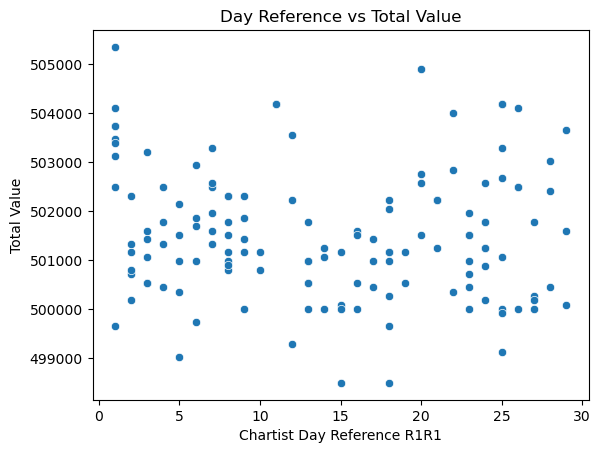

In [7]:
results_filtered_chartist = results_df[(results_df["AgentID"].str.contains("chartist"))]
results_filtered_chartist = results_filtered_chartist[(results_filtered_chartist.Step == 10)]

results_filtered_R1R1 = results_filtered_chartist[(results_filtered_chartist.OpenSMA == True)]
results_filtered_R1R1 = results_filtered_R1R1[(results_filtered_R1R1.CloseSMA == True)]
results_filtered_R1R1[["iteration", "chartist_day_reference", "TV"]].reset_index(
    drop=True
)

g_R1R1 = sns.scatterplot(data=results_filtered_R1R1, x="chartist_day_reference", y="TV")
g_R1R1.set(
    xlabel="Chartist Day Reference R1R1",
    ylabel="Total Value",
    title="Day Reference vs Total Value",
);

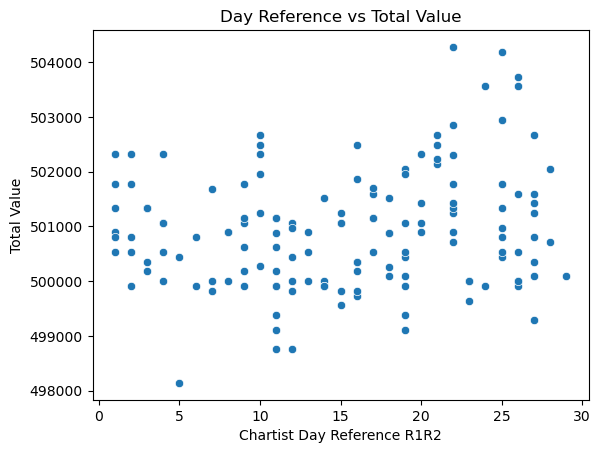

In [8]:
results_filtered_R1R2 = results_filtered_chartist[(results_filtered_chartist.OpenSMA == True)]
results_filtered_R1R2 = results_filtered_R1R2[(results_filtered_R1R2.CloseSMA == False)]
results_filtered_R1R2[["iteration", "chartist_day_reference", "TV"]].reset_index(
    drop=True
)

g_R1R2 = sns.scatterplot(data=results_filtered_R1R2, x="chartist_day_reference", y="TV")
g_R1R2.set(
    xlabel="Chartist Day Reference R1R2",
    ylabel="Total Value",
    title="Day Reference vs Total Value",
);

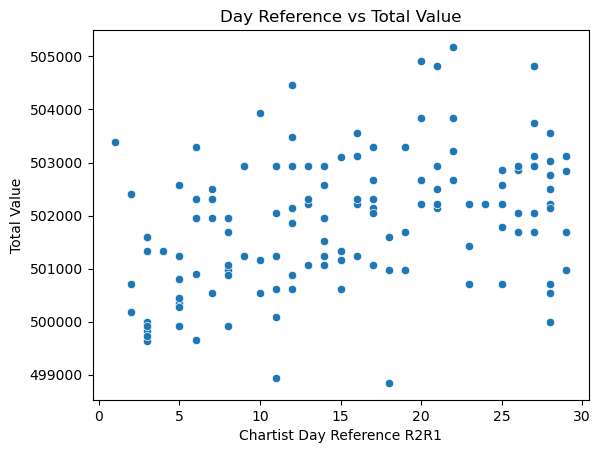

In [9]:
results_filtered_R2R1 = results_filtered_chartist[(results_filtered_chartist.OpenSMA == False)]
results_filtered_R2R1 = results_filtered_R2R1[(results_filtered_R2R1.CloseSMA == True)]
results_filtered_R2R1[["iteration", "chartist_day_reference", "TV"]].reset_index(
    drop=True
)

g_R2R1 = sns.scatterplot(data=results_filtered_R2R1, x="chartist_day_reference", y="TV")
g_R2R1.set(
    xlabel="Chartist Day Reference R2R1",
    ylabel="Total Value",
    title="Day Reference vs Total Value",
);

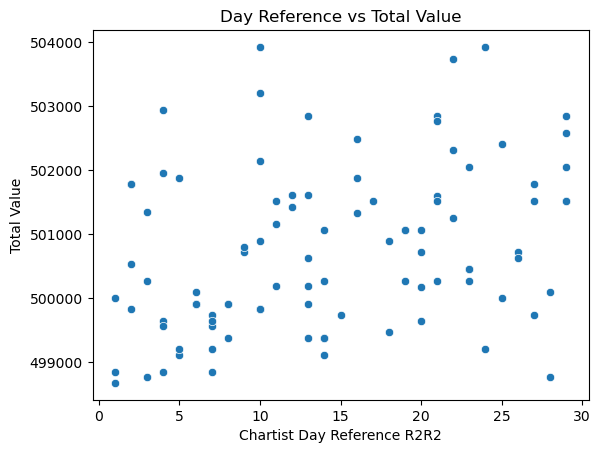

In [10]:
results_filtered_R2R2 = results_filtered_chartist[(results_filtered_chartist.OpenSMA == False)]
results_filtered_R2R2 = results_filtered_R2R2[(results_filtered_R2R2.CloseSMA == False)]
results_filtered_R2R2[["iteration", "chartist_day_reference", "TV"]].reset_index(
    drop=True
)

g_R2R2 = sns.scatterplot(data=results_filtered_R2R2, x="chartist_day_reference", y="TV")
g_R2R2.set(
    xlabel="Chartist Day Reference R2R2",
    ylabel="Total Value",
    title="Day Reference vs Total Value",
);

In [67]:
results_filtered_R1R1_ratio = results_filtered_R1R1.copy()
results_filtered_R1R1_ratio = results_filtered_R1R1_ratio.loc[:,["iteration", "Bitcoin", "Fiat"]]

bitcoin = pd.DataFrame(results_filtered_R1R1_ratio.groupby(['iteration']).sum()['Bitcoin'])
fiat = pd.DataFrame(results_filtered_R1R1_ratio.groupby(['iteration']).sum()['Fiat'])
final_df = bitcoin.join(fiat)
final_df["Ratio"] = final_df["Fiat"]/final_df["Bitcoin"]

results_filtered_R1R1_open = results_filtered_R1R1_ratio[(results_filtered_R1R1_ratio["Bitcoin"] > 0)]
results_filtered_R1R1_open = pd.DataFrame(results_filtered_R1R1_open.groupby(['iteration'])['Bitcoin'].count().reset_index(name="Open Position"))
# results_filtered_R1R1_open.rename(columns={'Bitcoin': 'Count'})
# print(results_filtered_R1R1_open.head(30))
results_filtered_R1R1_open = results_filtered_R1R1_open.drop('iteration', axis=1)
print(final_df.join(results_filtered_R1R1_open))

ratio = final_df.loc[:, 'Ratio'].mean()
print(f'average ratio : {ratio}')

             Bitcoin          Fiat         Ratio  Count
iteration                                              
0          1874.9373  1.202939e+07   6415.888839     21
1          1336.3897  1.405289e+07  10515.564869     15
2          2227.5231  1.255357e+07   5635.665344     25
average ratio : 7522.373017287234


In [ ]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_price_df = results_df.copy()
results_price_df = results_price_df.loc[:,["iteration", "Step", "Price"]]
results_price_df = results_price_df.groupby(['iteration', 'Step']).max()['Price']
results_price_df = results_price_df.groupby(["Step"]).mean()
print(results_price_df.groupby(["Step"]).mean())

fig = px.line(results_price_df, y = 'Price', title = 'Price', markers = True)

fig.show()

In [ ]:
total_bitcoin = 10000
total_fiat = 5000000

# Agents Parameters
number_of_agents = 5 # In 2020, there are 420M users
chartist_day_reference = 3
chartist_ratio = 0.5

price_start = 5614

model = BitcoinMarketModel(price_start, 
                           number_of_agents, 
                           total_fiat, 
                           total_bitcoin, 
                           chartist_ratio, 
                           chartist_day_reference)

for i in range(10):
#     print(f'progress : {i}/1399')
    model.step()
    
data = model.datacollector.get_model_vars_dataframe()

price_df = pd.DataFrame(data=data.Price)
fig = px.line(price_df, y = 'Price', title = 'Price', markers = True)

fig.show()

agent_variables = model.datacollector.get_agent_vars_dataframe()
end_state = agent_variables.index.get_level_values("Step").max()
end_state_total_value = agent_variables.xs(end_state, level="Step")["TV"]
agents_total_value_df = pd.DataFrame(data=end_state_total_value)

# # Create a histogram of wealth at the last step
counts, bins = np.histogram(agents_total_value_df, bins=range(0, 5000000, 1000000))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'total_values', 'y':'count'})
fig.show()